# Прогноз оттока клиентов для оператора связи

На основе информации о клиентах оператора связи, построить модель способную прогнозировать отток.

#### Описание услуг


Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

#### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#### Расшифровка колонок

* customerID - идентификационный номер клиента
* BeginDate - дата начала пользования услугами
* EndDate - дата окончания пользования услугами
* Type - тип оплаты: ежемесячный, годовой и тд
* PaperlessBilling – безналичный расчет
* PaymentMethod – способ оплаты
* MonthlyCharges – ежемесячные траты на услуги
* TotalCharges – всего потрачено денег на услуги
* Dependents – наличие иждивенцев
* Senior Citizen – наличие пенсионного статуса по возрасту
* Partner – наличие супруга(и)
* MultipleLines – наличие возможности ведения параллельных линий во время звонка

#### План выполнения проекта

1. Исследование данных
    * визуальный осмотр
    * вывод статистической информации
    * поиск пропусков и проверка типов данных
    * поиск дубликатов
2. Подготовка данных
    * объединение таблиц
    * пред обработка пропусков, дубликатов (при наличии)
    * изменение типов данных (при необходимости)
    * подготовка признаков для модели(добавление синтетических, удаление малоинформативных)
3. Подбор моделей
    * обучить и сравнить несколько моделей на кросс валидации, и выбрать наиболее подходящую
4. Подбор гиперпараметров и признакового пространства на кросс валидации
    * выбрать информативные признаки
    * подобрать гиперпараметры
5. Тестирование
    * проверка на тестовой выборке
6. Вывод

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


pd.set_option('display.max_columns', 30)
warnings.filterwarnings("ignore")

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

datasets = [contract, personal, internet, phone]

### Исследование данных

In [3]:
def view(data):
    print('Обзор данных', '\n')
    print(data.sample(10))
    print('\n')
    print('Информация о формате, количестве строк и пропусках', '\n')
    print(data.info())
    print('\n')
    print('Статистика', '\n')
    print(data.describe())
    print('-' * 65)
    print('\n' * 3)

In [4]:
for data in datasets:
    view(data)

Обзор данных 

             BeginDate              EndDate            Type PaperlessBilling  \
customerID                                                                     
3638-DIMPH  2019-01-01                   No        One year               No   
5914-DVBWJ  2018-05-01  2019-11-01 00:00:00  Month-to-month              Yes   
5167-ZFFMM  2019-10-01  2019-11-01 00:00:00  Month-to-month              Yes   
4232-JGKIY  2020-01-01                   No  Month-to-month               No   
5543-QDCRY  2019-10-01                   No  Month-to-month              Yes   
1062-LHZOD  2019-09-01  2019-10-01 00:00:00  Month-to-month              Yes   
4433-JCGCG  2016-02-01  2019-12-01 00:00:00  Month-to-month              Yes   
2972-YDYUW  2015-05-01                   No        One year               No   
5136-GFPMB  2015-08-01                   No  Month-to-month               No   
9769-TSBZE  2014-04-01                   No        Two year               No   

                      Pa

#### Вывод

Пропусков в данных нет, колонку total charges следует привести к числовому формату. Следует создать бинарный целевой признак.
От колонки с номером клиента следует избавиться, в связи с неинформативностью. Дата начала пользования услугами будет плохо масштабироваться в будущее, нужно попробовать на ее основе создать новый признак или исключить совсем.

### Подготовка данных

In [5]:
datasets[2]['internet'] = 'Yes'
datasets[3]['phone'] = 'Yes'

Добавим признак пользуется ли клиент интернетом и пользуется ли телефоном

In [6]:
df = contract.join(datasets[1:]).reset_index()

Совместили таблицы по индексу

In [7]:
df.duplicated().sum()

0

После совмещение дубликатов нет

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
internet            5517 non-null object
MultipleLines       6361 non-null object
phone               6361 non-nul

In [9]:
df = df.fillna('No')

Так как пропуски обусловленные тем что, клиенты не пользовались теми или иными видами услуг, смело заменяем на 'No'.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
internet            7043 non-null object
MultipleLines       7043 non-null object
phone               7043 non-nul

In [11]:
df.loc[df['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes


In [12]:
df = df.loc[df['TotalCharges']!=' ']

11 клиентов подключились в день сбора данных и по ним еще нет данных об общих платежах, лучше удалить их. На этапе подготовки данных для модели, мы не можем  протестировать на них, ни собрать полезную информацию, они вносят только шум.

In [13]:
df.loc[df['BeginDate'] >= '2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone


Неразмеченных данных, больше нет

In [14]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [15]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
#df['begin_month'] = df['BeginDate'].dt.month

Извлекаем месяц, возможно есть сезонные подключения на короткий срок

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
internet            7032 non-null object
MultipleLines       7032 non-null object
phone               703

In [17]:
gone = df.loc[df['EndDate'] != 'No']

In [18]:
stayed = df.loc[df['EndDate'] == 'No']

In [19]:
gone['EndDate'] = pd.to_datetime(gone['EndDate'])

In [20]:
gone['together'] = round((gone['EndDate'] - gone['BeginDate'])/np.timedelta64(1, 'D'))

In [21]:
gone['MonthlyCharges'].describe()

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: MonthlyCharges, dtype: float64

In [22]:
df['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

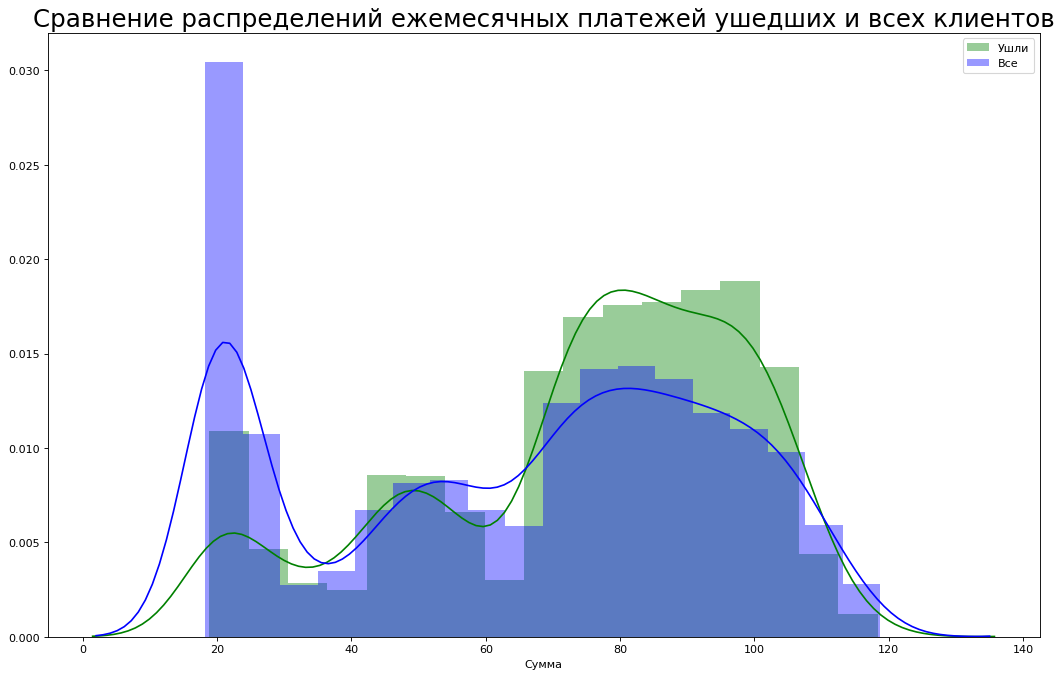

In [23]:
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(gone['MonthlyCharges'], color="g", label="Ушли")
sns.distplot(df['MonthlyCharges'], color="b", label="Все")

plt.title('Сравнение распределений ежемесячных платежей ушедших и всех клиентов', fontsize=22)
plt.legend()
plt.xlabel('Сумма')
plt.show()

Мы видим что чаще уходят клиенты у которых ежемесячные траты выше. Полимодальное распределение с тремя модами позволяет предположить, что есть три базовых тарифа. Клиенты тратящие больше  уходят чаще.

In [24]:
gone['together'].describe()

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: together, dtype: float64

Четверть уходящих клиентов, уходят в первый месяц, половина в первые 10 месяцев

In [25]:
df = df.drop(columns='customerID')

Удалили номера клиентов, в связи с не информативностью

In [26]:
df.loc[df['EndDate'] != 'No', 'left'] = 1
df.loc[df['EndDate'] == 'No', 'left'] = 0  
df['left'] = df['left'].astype(int)

Создали бинарный целевой признак

In [27]:
df.loc[df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['together'] = round((df['EndDate'] - df['BeginDate'])/np.timedelta64(1, 'D')).astype(int)
df = df.drop(columns=['EndDate', 'BeginDate'])

In [50]:
df.together.sort_values()

2133      30
6623      30
3310      30
6633      30
248       30
        ... 
850     2191
6778    2191
2941    2191
4513    2191
932     2191
Name: together, Length: 7032, dtype: int64

In [51]:
df[df.together < 50]

,TotalCharges,SeniorCitizen,left,together,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,phone_Yes
0,29,0,0,31,0,0,1,1,0,0,0,0,0,0,0,0,0,0
20,39,1,1,30,0,0,1,1,0,1,0,0,0,0,0,1,0,0
22,20,0,1,30,0,0,0,0,1,1,0,1,0,0,0,0,0,1
27,30,0,1,30,0,0,0,1,0,1,0,0,0,0,0,0,0,0
33,20,0,0,31,0,0,0,0,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,24,0,0,31,0,0,0,0,1,1,0,0,0,0,0,0,0,0
7010,74,1,1,30,0,0,1,1,0,0,1,0,0,0,0,0,1,1
7016,49,0,0,31,0,0,0,1,0,0,0,0,0,0,0,0,0,1
7018,70,0,1,31,0,0,1,0,1,1,1,0,0,0,0,0,0,1


Посчитали сколько клиент снами. BeginDate, EndDate нам больше не нужны мы извлекли из них всю полезную информацию.

In [28]:
df.describe(include='all')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone,left,together
count,7032,7032,7032,7032.000000,7032.000000,7032,7032.000000,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000
unique,3,2,4,NaN,NaN,2,NaN,2,2,3,2,2,2,2,2,2,2,2,2,NaN,NaN
top,Month-to-month,Yes,Electronic check,NaN,NaN,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,Yes,No,Yes,NaN,NaN
freq,3875,4168,2365,NaN,NaN,3549,NaN,3639,4933,3096,5017,4607,4614,4992,4329,4301,5512,4065,6352,NaN,NaN
mean,NaN,NaN,NaN,64.798208,2283.300441,NaN,0.162400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265785,987.538538
std,NaN,NaN,NaN,30.085974,2266.771362,NaN,0.368844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441782,747.153663
min,NaN,NaN,NaN,18.250000,18.800000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,30.000000
25%,NaN,NaN,NaN,35.587500,401.450000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,275.000000
50%,NaN,NaN,NaN,70.350000,1397.475000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,883.000000
75%,NaN,NaN,NaN,89.862500,3794.737500,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1676.000000


In [29]:
def cat_type(df, col):
    print(col)
    print(df[col].unique())
    print()
    return df

In [30]:
categorial = ['Type', 'InternetService', 'Partner', 'DeviceProtection', 'gender', 'OnlineBackup', 'Dependents',
              'PaperlessBilling', 'StreamingTV','MultipleLines', 'SeniorCitizen', 'TechSupport','OnlineSecurity',
              'StreamingMovies', 'PaymentMethod','phone', 'internet']

In [31]:
for i in categorial:
    cat_type(df, i)

Type
['Month-to-month' 'One year' 'Two year']

InternetService
['DSL' 'Fiber optic' 'No']

Partner
['Yes' 'No']

DeviceProtection
['No' 'Yes']

gender
['Female' 'Male']

OnlineBackup
['Yes' 'No']

Dependents
['No' 'Yes']

PaperlessBilling
['Yes' 'No']

StreamingTV
['No' 'Yes']

MultipleLines
['No' 'Yes']

SeniorCitizen
[0 1]

TechSupport
['No' 'Yes']

OnlineSecurity
['No' 'Yes']

StreamingMovies
['No' 'Yes']

PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

phone
['No' 'Yes']

internet
['Yes' 'No']



In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
internet            7032 non-null object
MultipleLines       7032 non-null object
phone               7032 non-null object
left                7032 non-null int64
together            7032 non-null int64
dtypes: float64(2), int64(3), obj

In [33]:
df = pd.get_dummies(df, drop_first=True).astype(int)

In [34]:
df = df.drop(columns=['Partner_Yes', 'DeviceProtection_Yes','PaymentMethod_Credit card (automatic)',
                      'internet_Yes', 'OnlineBackup_Yes','Dependents_Yes'])

Удалили лишние признаки

In [35]:
df['MonthlyCharges'].corr(df['TotalCharges'])

0.6511252380434778

Есть небольшая корреляция между количественными признаками, буду эмпирически выяснять как лучше (убирая один признак, или используя оба).

In [38]:
df = df.drop(columns=['MonthlyCharges']) # эмперическим путем оказалось лучшим. вариантом оставить "TotalCharges"

In [39]:
df

,TotalCharges,SeniorCitizen,left,together,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,phone_Yes
0,29,0,0,31,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,1889,0,0,1036,1,0,0,0,1,1,0,0,1,0,0,0,0,1
2,108,0,1,61,0,0,1,0,1,1,0,0,1,0,0,0,0,1
3,1840,0,0,1371,1,0,0,0,0,1,0,0,1,1,0,0,0,0
4,151,0,1,61,0,0,1,1,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1990,0,0,730,1,0,1,0,1,1,0,0,1,1,1,1,1,1
7039,7362,0,0,2191,1,0,1,0,0,0,1,0,0,0,1,1,1,1
7040,346,0,0,337,0,0,1,1,0,0,0,0,1,0,0,0,0,0
7041,306,1,1,123,0,0,1,0,1,1,1,0,0,0,0,0,1,1


In [40]:
one_class_waight = df.loc[df['left'] == 1].shape[0] / df['left'].shape[0]
zero_class_waight = 1 - one_class_waight
class_waights = [ one_class_waight, zero_class_waight]
class_waights

[0.26578498293515357, 0.7342150170648465]

Есть существенный дисбаланс классов целевого признака. Создали список весов, для передачи в Catboost

In [41]:
train,test = train_test_split(df, test_size=0.2, random_state = 42, stratify= df['left'])

Разбили на трейн, тест 

In [42]:
def features_target_split(df,target):
    features = df.drop(target, axis=1)
    target = df[target]
    return features, target

In [43]:
features_test, target_test = features_target_split(test,'left')
features_train, target_train = features_target_split(train,'left')

Отделили целевой признак

### Подбор моделей

In [44]:
models_scors = pd.DataFrame(columns = ['model', 'roc_auc']) # таблица для сбора метрик

#### RandomForrestClassifier

In [45]:
%%time
RF_model = RandomForestClassifier(random_state=42, class_weight='balanced')

parameters = [{'max_depth': [7],
               'n_estimators': [270]}]

RF_model_gscv = GridSearchCV(RF_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
RF_model_gscv.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'RandomForest',
                     'roc_auc' : RF_model_gscv.best_score_}, ignore_index=True)

RF_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.1s finished


CPU times: user 4.29 s, sys: 0 ns, total: 4.29 s
Wall time: 4.31 s


{'max_depth': 7, 'n_estimators': 270}

#### CatBoostClassifier

In [46]:
%%time
CBC_model = CatBoostClassifier(random_state=42, silent=True, class_weights=class_waights)

parameters = [{'max_depth': [2],
               'learning_rate': [0.3],
               'n_estimators': [800]}]

CBC_model_gscv = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'CatBoostClassifier',
                     'roc_auc' : CBC_model_gscv.best_score_}, ignore_index=True)

CBC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.1s finished


CPU times: user 31.6 s, sys: 2.75 s, total: 34.4 s
Wall time: 39.9 s


{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}

#### LGBMClassifier

In [47]:
%%time
LGBMC_model = LGBMClassifier(random_state=42, class_weight='balanced')

parameters = [{'max_depth': [2],
               'learning_rate': [0.1],
               'n_estimators': [700]}]

LGBMC_model_gscv = GridSearchCV(LGBMC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
LGBMC_model_gscv.fit(features_train, target_train)

models_scors = models_scors.append({'model' : 'LGBMClassifier',
                     'roc_auc' : LGBMC_model_gscv.best_score_ }, ignore_index=True)

LGBMC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.4s finished


CPU times: user 8.5 s, sys: 29.5 ms, total: 8.53 s
Wall time: 8.67 s


{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 700}

In [48]:
models_scors

,model,roc_auc
0,RandomForest,0.862737
1,CatBoostClassifier,0.933095
2,LGBMClassifier,0.904604


Лучшие результаты продемонстрировал CatBoost, будем подбирать фичи для него

### Подбор фичей и гиперпараметров

In [49]:
%%time
CBC_model = CatBoostClassifier(random_state=42, silent=True, class_weights=class_waights)

parameters = [{'max_depth': [2],
               'learning_rate': [0.3],
               'n_estimators': [800]}]

CBC_model_gscv = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_train, target_train)


CBC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   29.1s finished


CPU times: user 32.4 s, sys: 3.01 s, total: 35.4 s
Wall time: 40.2 s


{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}

In [50]:
CBC_model_gscv.best_score_

0.9330946863144465

In [51]:
features_train_importance = pd.DataFrame({'name' : features_train.columns,
                                          'importance' : CBC_model_gscv.best_estimator_.feature_importances_})
features_train_importance = features_train_importance.sort_values('importance', ascending=False)
features_train_importance

,name,importance
2,together,76.834638
0,TotalCharges,7.580627
4,Type_Two year,4.965636
9,InternetService_Fiber optic,2.775612
3,Type_One year,1.764657
10,InternetService_No,1.664094
6,PaymentMethod_Electronic check,0.961378
13,StreamingTV_Yes,0.474337
14,StreamingMovies_Yes,0.473446
1,SeniorCitizen,0.416032


### Тестирование

In [52]:
print('ROC-AUC : {:.2f}'.format(roc_auc_score(target_test,
                                        CBC_model_gscv.best_estimator_.predict_proba(features_test)[:, 1])))

ROC-AUC : 0.94


In [53]:
print('Accuracy : {:.2%}'.format(accuracy_score(target_test,
                                                CBC_model_gscv.best_estimator_.predict(features_test))))

Accuracy : 87.06%


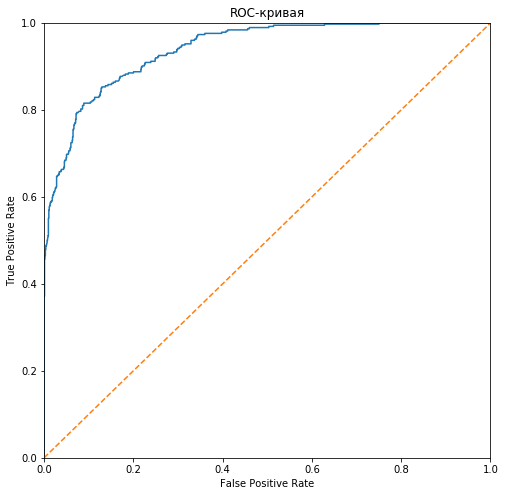

In [54]:
fpr, tpr, thresholds = roc_curve(target_test, CBC_model_gscv.best_estimator_.predict_proba(features_test)[:, 1])

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Вывод

Наша модель добилась хороших результатов, площадь под ROC кривой на тестовой выборки составляет 0.94. Точность 87.06%.

Самым важным признаком является продолжительность пользования услугами, чем дольше клиент с компанией, тем меньше вероятность, что он покинет её. Следующая по важности фича - сколько в общем клиент уже заплатил компании. Чаще всего уходят клиенты с большей платой в месяц. 25% клиентов уходит после первого месяца, 50% в течение 10 месяцев.

### Отчет

1. Исследовательский анализ данных.
 * Был произведен визуальный осмотр данных, статистической информации, проверка на пропуски и дубликаты.

2. Подготовка данных.
 * Удалена дата подключения. Проанализирован период через который происходит прекращение пользования услугами.   Произведено объединение таблиц и добавление признаков "пользование интернетом" и "пользование телефонией". Образовавшиеся пропуски были заполнены значением "No", так как явно было указано, что если клиента нет в таблице, значит он не пользуется услугой. Удален признак "ежемесячный платеж" в связи с корреляцией с другим количественным признаком(эффективность эмпирически проверена). Построен график распределений всех клиентов, и тех кто ушел.

3. Подбор модели.
 * На кросс валидации было произведено сравнение трех моделей.

4. Подбор гиперпараметров.
 * Были отсеяны мало информативные признаки, после этого ещё раз были подобраны гиперпараметры.

5. Тестирование.
 * Модель была протестирована на тестовой выборке выведены метрики ROC-AUC : 0.94, Accuracy : 87.06% и построена ROC-кривая.
 
Изначально ошибочно добавил параметр месяц подключения, что вызвало сверх точность модели, в последствии отказался от него.  Заметил интересную особенность, при извлечении признака "время которое клиент провел с компанией", если округлять до месяца точность моделей существенно падает. Несмотря на то, что количество дней явно привязано к месяцам(30, 61 и т.д.). 